<a href="https://colab.research.google.com/github/GenAIUnplugged/tensorflow_series/blob/main/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D,  GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
(ds_train,ds_test),ds_info = tfds.load(
    'fashion_mnist',
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

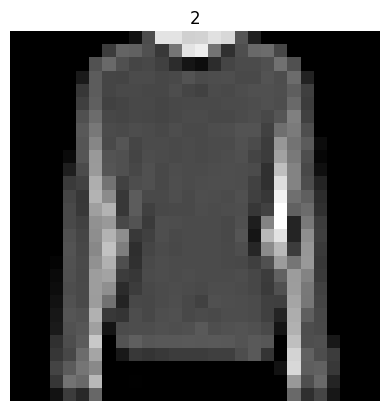

In [3]:
for image,label in ds_train.take(1):
    plt.imshow(image,cmap='gray')
    plt.title(str(label.numpy()))
    plt.axis('off')

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [5]:
# Define image size and batch size
IMG_SIZE = 28
BATCH_SIZE = 32
NUM_CLASSES = ds_info.features['label'].num_classes

In [6]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

In [7]:
# Apply preprocessing
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
# Shuffle, batch, cache, and prefetch
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [26]:
# Add Data Augmentation Layers
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    # You could add more layers here like RandomZoom, RandomContrast, etc.
], name="data_augmentation")

In [27]:
from tensorflow.keras.layers import Dropout,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
    # Add data augmentation layers first
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 1)),
    layers.MaxPooling2D(),
    Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    Dropout(0.5),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),  # Replaces Flatten
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
# Define Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping: Stop training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [30]:
# Train the model
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5283 - loss: 1.2482 - val_accuracy: 0.7359 - val_loss: 0.6884
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7290 - loss: 0.7202 - val_accuracy: 0.7835 - val_loss: 0.5814
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7569 - loss: 0.6514 - val_accuracy: 0.8032 - val_loss: 0.5368
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7732 - loss: 0.6133 - val_accuracy: 0.8130 - val_loss: 0.5042
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7847 - loss: 0.5895 - val_accuracy: 0.8217 - val_loss: 0.4841
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.7899 - loss: 0.5741 - val_accuracy: 0.8253 - val_loss: 0.4821
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7954 - loss: 0.5586 - val_accuracy: 0.8218 - val_loss: 0.4848
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7980 - loss: 0

In [31]:
loss,acc = model.evaluate(ds_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8625 - loss: 0.3916


In [32]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

Test Loss: 0.4018
Test Accuracy: 0.8572


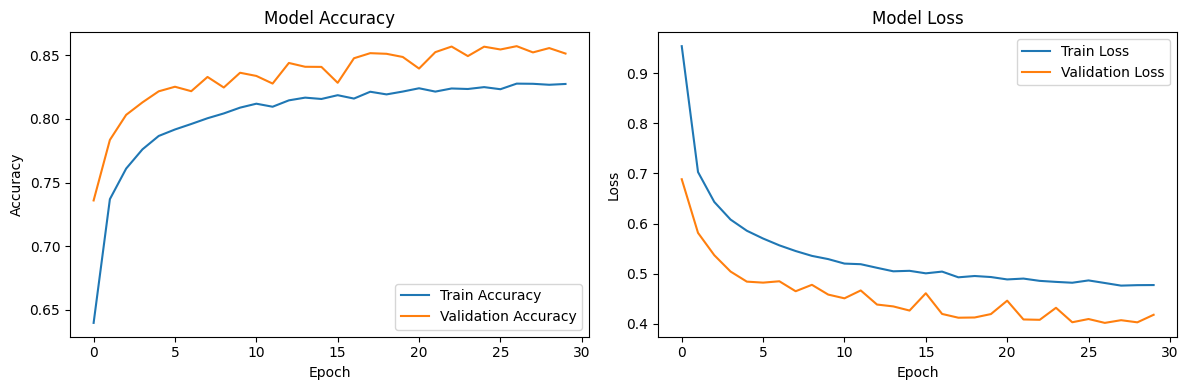

In [33]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

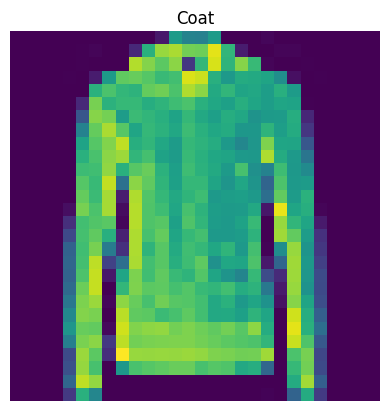

In [34]:
# Get the label names
get_label_name = ds_info.features['label'].int2str

# Fetch one batch
for image_batch, label_batch in ds_train.take(1):
    # Select the first image and label from the batch
    image = image_batch[0].numpy()
    label = tf.argmax(label_batch[0]).numpy() # Use tf.argmax and convert to numpy for display
    plt.imshow(image)
    plt.axis('off')
    plt.title(get_label_name(label))
    plt.show()

In [35]:
type(get_label_name)

method

Saving the model

In [37]:
import joblib
joblib.dump(model,'model.pkl')
model = joblib.load('model.pkl')

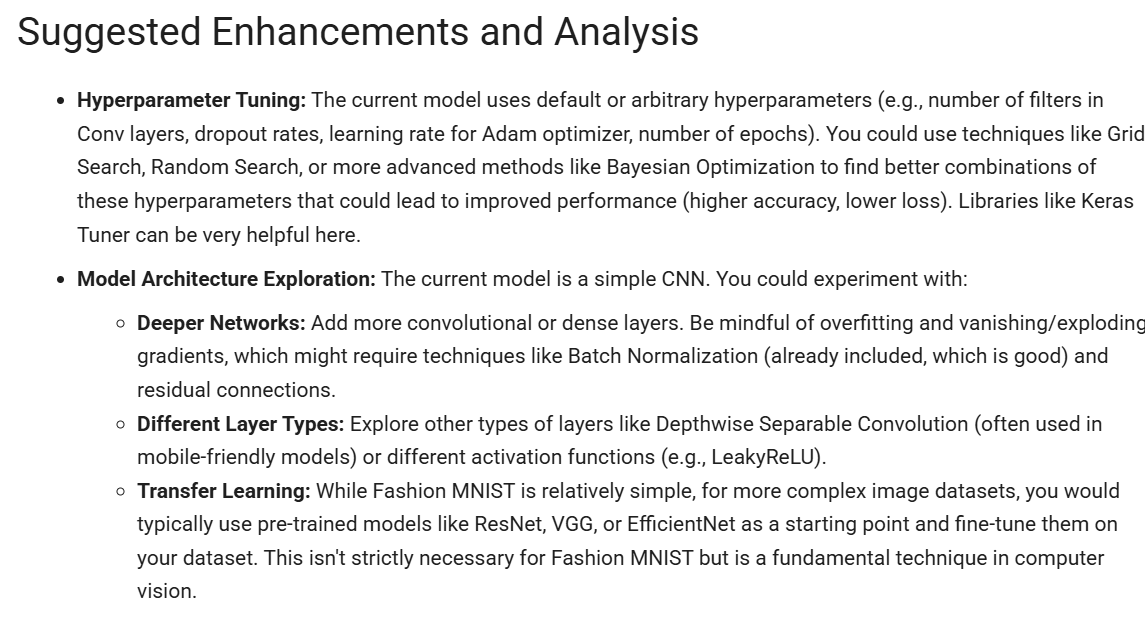

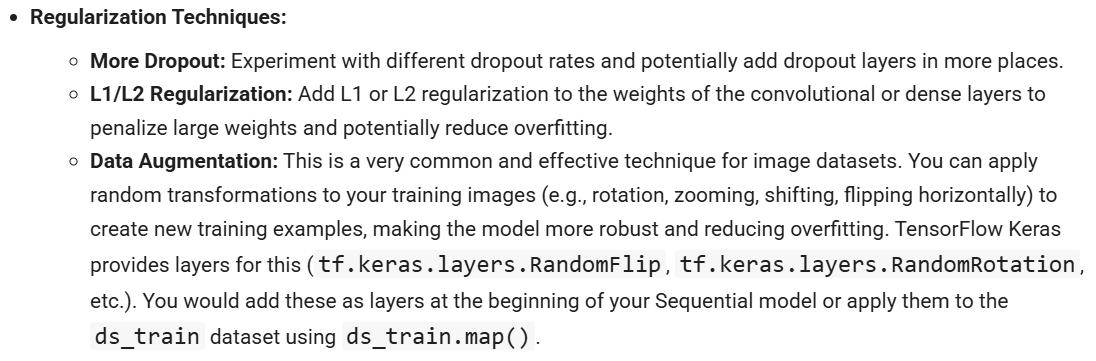

![image.png](")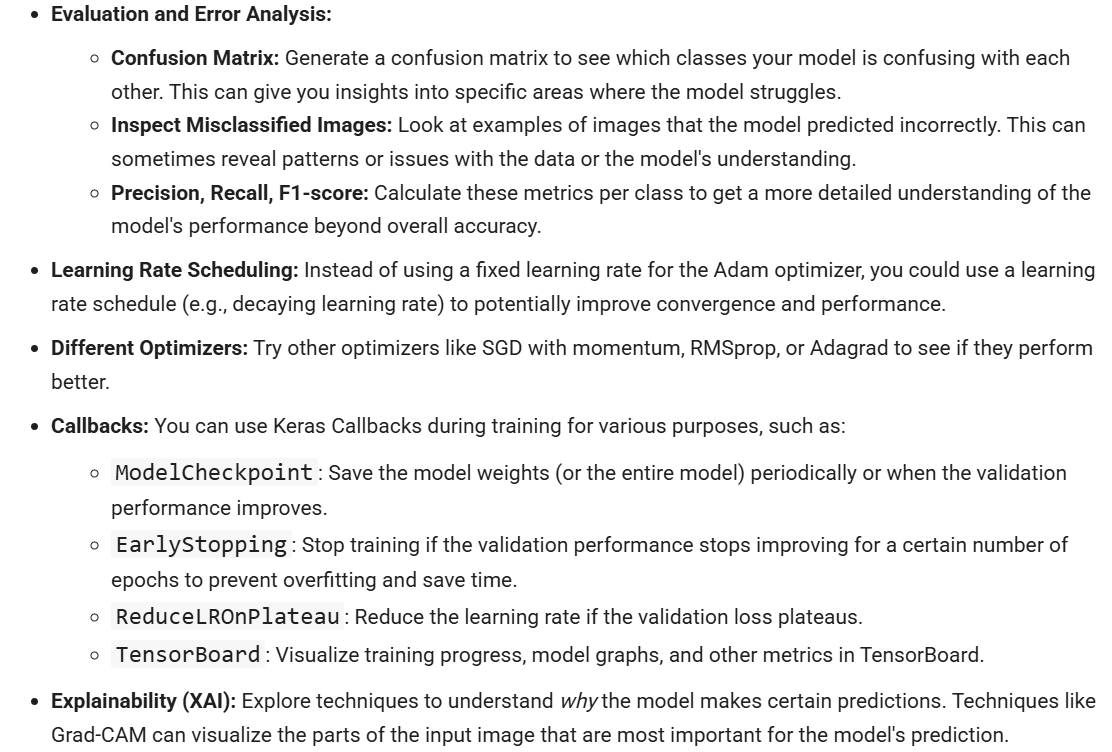